In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt

In [2]:
model_mn2 = MobileNetV2(
    input_shape=None, alpha=1.0, include_top=True, weights='imagenet',
    input_tensor=None, pooling=None, classes=1000
)

model_mn2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [3]:
layer_name = 'block_15_add'
feature_extractor = Model(inputs=model_mn2.input, outputs=model_mn2.get_layer(layer_name).output)

In [4]:
diseases_names = []

for diseases in os.listdir('datasets/encoded/PlantDoc/train'):
    diseases_names += [diseases.split('.npy')[0]]

diseases_names.sort()
plant_name_to_id = {plant: i for i, plant in enumerate(diseases_names)}

In [5]:
instances = {}
labels = {}

for set_kind in ["test", "train", "val"]:
    X_per_class = []
    y_per_class = []

    for i, file in enumerate(os.listdir(f'datasets/encoded/PlantDoc/{set_kind}')):
        print(f"\r[{i}] {set_kind}/{file}", end='')
        plants_encoded = np.load(f'datasets/encoded/PlantDoc/{set_kind}/{file}')
        plant_name = file.split('.npy')[0]

        X_per_class += [plants_encoded]
        y_per_class += [plant_name_to_id[plant_name] for _ in range(plants_encoded.shape[0])]

    instances[set_kind] = np.concatenate(X_per_class)
    labels[set_kind] = np.array(y_per_class)

[26] val/Tomato Septoria leaf spot.npyyyy

In [6]:
n_classes = len(diseases_names)

X_train = instances['train']
y_train = np.eye(n_classes)[labels['train']]


X_valid = instances['val']
y_valid = np.eye(n_classes)[labels['val']]

X_test = instances['test']
y_test = np.eye(n_classes)[labels['test']]

In [7]:
print(X_train[0].shape)

(7, 7, 160)


In [8]:
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

In [9]:
input_layer = tf.keras.layers.Input(shape=[7, 7, 160], name="submodel_inputs")
intermediate = tf.keras.layers.Conv2D(filters=960, kernel_size=1, use_bias=False, name="block_16_expand")(input_layer)
intermediate = tf.keras.layers.BatchNormalization(name="block_16_expand_BN")(intermediate)
intermediate = tf.keras.layers.ReLU(name="block_16_expand_relu")(intermediate)
intermediate = tf.keras.layers.DepthwiseConv2D(
    kernel_size=3, padding='same', use_bias=False, name="block_16_depthwise")(intermediate)
intermediate = tf.keras.layers.BatchNormalization(name="block_16_depthwise_BN")(intermediate)
intermediate = tf.keras.layers.ReLU(name="block_16_depthwise_relu")(intermediate)
intermediate = tf.keras.layers.Conv2D(filters=320, kernel_size=1, use_bias=False, name="block_16_project")(intermediate)
intermediate = tf.keras.layers.BatchNormalization(name="block_16_project_BN")(intermediate)
intermediate = tf.keras.layers.Conv2D(filters=1280, kernel_size=1, use_bias=False, name="Conv_1")(intermediate)
intermediate = tf.keras.layers.BatchNormalization(name="Conv_1_bn")(intermediate)
intermediate = tf.keras.layers.ReLU(name="out_relu")(intermediate)
intermediate = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling2d")(intermediate)
intermediate = tf.keras.layers.Dropout(rate=0.8, name="dropout")(intermediate)
output_layer = tf.keras.layers.Dense(
    units=27, activation="softmax", kernel_regularizer=keras.regularizers.l1(0.01), name="predictions")(intermediate)

model = Model(input_layer, output_layer)
model.summary()

for layer in model.layers:
    if layer.name not in ["submodel_inputs", "dropout", "predictions"]:
        layer.set_weights(model_mn2.get_layer(layer.name).get_weights())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 submodel_inputs (InputLayer  [(None, 7, 7, 160)]      0         
 )                                                               
                                                                 
 block_16_expand (Conv2D)    (None, 7, 7, 960)         153600    
                                                                 
 block_16_expand_BN (BatchNo  (None, 7, 7, 960)        3840      
 rmalization)                                                    
                                                                 
 block_16_expand_relu (ReLU)  (None, 7, 7, 960)        0         
                                                                 
 block_16_depthwise (Depthwi  (None, 7, 7, 960)        8640      
 seConv2D)                                                       
                                                           

In [10]:
filepath = 'model_mobilenetv2_regularized_plantdoc'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='min')

model.compile(
    loss="categorical_crossentropy",
    optimizer="nadam",
    metrics=["accuracy"]
)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.66, patience=1)
idx = np.arange(X_train.shape[0])
np.random.shuffle(idx)

X_train_shuffled = X_train[idx]
y_train_shuffled = y_train[idx]

history = model.fit(
    X_train_shuffled, y_train_shuffled,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, checkpoint]
)

Epoch 1/50
906/906 [==============================] - ETA: 0s - loss: 3.2071 - accuracy: 0.5620      

INFO:tensorflow:Assets written to: model_mobilenetv2_regularized_plantdoc\assets
INFO:tensorflow:Assets written to: model_mobilenetv2_regularized_plantdoc\assets
INFO:tensorflow:Assets written to: model_mobilenetv2_regularized_plantdoc\assets
INFO:tensorflow:Assets written to: model_mobilenetv2_regularized_plantdoc\assets
INFO:tensorflow:Assets written to: model_mobilenetv2_regularized_plantdoc\assets
INFO:tensorflow:Assets written to: model_mobilenetv2_regularized_plantdoc\assets
INFO:tensorflow:Assets written to: model_mobilenetv2_regularized_plantdoc\assets
INFO:tensorflow:Assets written to: model_mobilenetv2_regularized_plantdoc\assets
INFO:tensorflow:Assets written to: model_mobilenetv2_regularized_plantdoc\assets
INFO:tensorflow:Assets written to: model_mobilenetv2_regularized_plantdoc\assets
INFO:tensorflow:Assets written to: model_mobilenetv2_regularized_plantdoc\assets
INFO:tensorflow:Assets written to: model_mobilenetv2_regularized_plantdoc\assets
INFO:tensorflow:Assets writt

In [11]:
def top_k_accuracy_score(y_true, y_pred, k=1):
    ranks = np.sum(y_pred >= y_pred[y_true == 1].reshape(-1, 1), axis=1)
    return np.sum(ranks <= k) / ranks.shape[0]

model_mobilenetv2_regularized = tf.keras.models.load_model("model_mobilenetv2_regularized_plantdoc")

batch_size = 32
num_batches = len(X_valid) // batch_size
X_valid_batches = np.array_split(X_valid, num_batches)
y_valid_batches = np.array_split(y_valid, num_batches)
top_1_accuracy_scores = []
top_5_accuracy_scores = []

for X_batch, y_batch in zip(X_valid_batches, y_valid_batches):
    X_batch = tf.reshape(X_batch, [-1, 7, 7, 160])
    y_pred = model_mobilenetv2_regularized(X_batch).numpy()
    top_1_accuracy_scores.append(top_k_accuracy_score(y_batch, y_pred, k=1))
    top_5_accuracy_scores.append(top_k_accuracy_score(y_batch, y_pred, k=5))

mean_top_1_accuracy = np.mean(top_1_accuracy_scores)
mean_top_5_accuracy = np.mean(top_5_accuracy_scores)

print("Validation set accuracy")
print("TOP 1 accuracy:", mean_top_1_accuracy)
print("TOP 5 accuracy:", mean_top_5_accuracy)


Validation set accuracy
TOP 1 accuracy: 0.5782539682539684
TOP 5 accuracy: 0.845952380952381


In [12]:
batch_size = 32
num_batches = len(X_test) // batch_size
X_test_batches = np.array_split(X_test, num_batches)
y_test_batches = np.array_split(y_test, num_batches)
top_1_accuracy_scores = []
top_5_accuracy_scores = []

for X_batch, y_batch in zip(X_test_batches, y_test_batches):
    X_batch = tf.reshape(X_batch, [-1, 7, 7, 160])
    y_pred = model_mobilenetv2_regularized(X_batch).numpy()
    top_1_accuracy_scores.append(top_k_accuracy_score(y_batch, y_pred, k=1))
    top_5_accuracy_scores.append(top_k_accuracy_score(y_batch, y_pred, k=5))

mean_top_1_accuracy = np.mean(top_1_accuracy_scores)
mean_top_5_accuracy = np.mean(top_5_accuracy_scores)

print("Test set accuracy")
print("TOP 1 accuracy:", mean_top_1_accuracy)
print("TOP 5 accuracy:", mean_top_5_accuracy)

Test set accuracy
TOP 1 accuracy: 0.5751209574738987
TOP 5 accuracy: 0.8975044563279857


In [13]:
model_mnv2 = keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3), dtype=tf.uint8),
    keras.layers.Lambda(lambda x: tf.cast(x, dtype=tf.float32)),
    keras.layers.Lambda(
        tf.keras.applications.mobilenet_v2.preprocess_input,
        name='preprocessing',
        input_shape=(224, 224, 3),
        dtype=tf.float32),
    feature_extractor,
    model_mobilenetv2_regularized
])

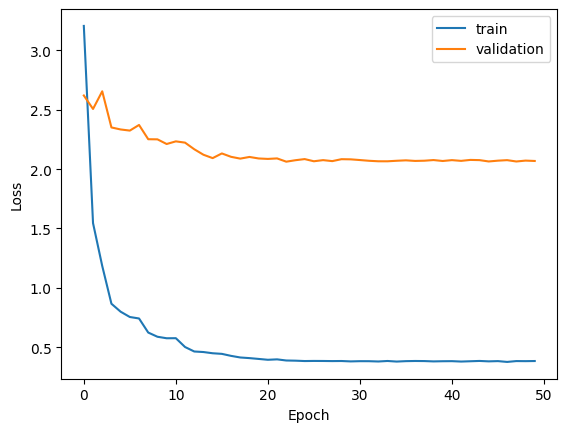

In [14]:
plt.plot((history.history['loss']), label='train')
plt.plot((history.history['val_loss']), label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig('mn_v2_plantdoc_learning_curves.png')
plt.show()

